* [Vanilla VAE](#Vanilla-VAE)
    * [Imports](#Imports)
    * [Settings](#Settings)
    * [MNIST Dataset](#MNIST-Dataset)
    * [Vanilla VAE Architecture](#Vanilla-VAE-Architecture)
    * [Training Loop](#Training-Loop)
* [VAE with Planar Flows](#VAE-with-Planar-Flows)
    * [VAE + PF Architecture](#VAE-+-PF-Architecture)
    * [VAE + PF Training Loop](#VAE-+-PF-Training-Loop)
    * [Comparing Vanilla VAe and VAE+PF](#Compare-Vanilla-VAE-and-VAE+PF)
* [Testing](#Testing)
* [Comparing Reconstructions](#Comparing-Reconstructions)
* [Data Generation](#Data-Generation)

# Vanilla VAE

### Imports

In [1]:
import numpy as np                             
import torch                                   
import torchvision                            
import torchvision.transforms as transforms    
from torch.utils.data import DataLoader        
from torchvision.utils import make_grid       
from torchvision.datasets import MNIST       
import matplotlib.pyplot as plt               
import torch.nn as nn                         
import torch.nn.functional as F                
import torch.optim as optim                   
from torch.distributions import MultivariateNormal
from math import log, pi

### Settings

In [2]:
# Neural Network Architecture               
e_hidden = 500       
d_hidden = 500        
latent_dim = 2    

# Optimizer 
learning_rate = 0.001 
weight_decay = 1e-5 

# Learning
epochs = 100
batch_size = 100

# Use GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### MNIST Dataset

In [3]:
t = transforms.Compose([transforms.ToTensor()])

# Use transformation for both training and test set
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=t)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=t)

# Load train and test set
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

### Vanilla VAE Architecture

In [4]:
class VAE_vanilla(nn.Module):
    def __init__(self, e_hidden, d_hidden, latent_dim):
        """Define encoding and decoding layers."""
        super(VAE_vanilla, self).__init__()
        # Encoding Layers
        self.e_input2hidden = nn.Linear(in_features=784, out_features=e_hidden)
        self.e_hidden2mean = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        self.e_hidden2logvar = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        
        # Decoding Layers
        self.d_latent2hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
        self.d_hidden2image = nn.Linear(in_features=d_hidden, out_features=784)
        
    def encode(self, x):
        """Transforms data into latent mean and latent log variance."""
        h = F.relu(self.e_input2hidden(x))
        # Return mu and logvar
        return self.e_hidden2mean(h), self.e_hidden2logvar(h)
    
    def decode(self, z):
        """This step decodes a latent variable."""
        return torch.sigmoid(self.d_hidden2image(torch.relu(self.d_latent2hidden(z))))
        
    def forward(self, x):
        """Describes how an input x gets fed through the network to obtain a reconstruction and 
        any other variable needed to compute the objective function."""
        # Shape Flatten image to [batch_size, input_features]
        x = x.view(-1, 784)
        
        # Feed x into Encoder to obtain mean and logvar
        mu, logvar = self.encode(x)
        
        # Sample z from latent space using mu and logvar
        if self.training:
            z = torch.randn_like(mu).mul(torch.exp(0.5*logvar)).add_(mu)
        else:
            z = mu
        
        # Feed z into Decoder to obtain reconstructed image. Use Sigmoid as output activation (=probabilities)
        recon = self.decode(z)
        
        return recon, mu, logvar

### Training Loop

In [5]:
# Send VAE parameters to GPU for faster computation, set up optimizer and set VAE to training mode.
vae = VAE_vanilla(e_hidden, d_hidden, latent_dim)
vae = vae.to(device)
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
vae.train()

# Store all losses here
losses = []

for epoch in range(epochs):
    # Initiate loss and set n batches to zero
    losses.append(0)
    number_of_batches = 0

    for images, _ in trainloader:
        # Send image to GPU
        images = images.to(device)     # (batch_size, 1, 28, 28)

        # Zero gradients, feed data through VAE
        optimizer.zero_grad()                                               
        recon, mu, logvar = vae(images)    
        
        # Compute Loss & Backpropagate gradients
        BCE = F.binary_cross_entropy(recon.view(-1, 784), images.view(-1, 784), reduction='sum') # -Bern likelihood
        KL  = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = BCE + KL  
        loss.backward()

        # Use the accumulated gradients to do a step in the right direction
        optimizer.step()

        # Add loss to the cumulative sum
        losses[-1] += loss.item() 
        number_of_batches += 1

    # At the end of all batches divide the total loss for this epoch by the number of 
    # batches to obtain an average loss per batch
    losses[-1] /= number_of_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, epochs, losses[-1]))    

Epoch [1 / 100] average reconstruction error: 18334.372157
Epoch [2 / 100] average reconstruction error: 16487.769705
Epoch [3 / 100] average reconstruction error: 16143.225807
Epoch [4 / 100] average reconstruction error: 15913.884976
Epoch [5 / 100] average reconstruction error: 15745.672461
Epoch [6 / 100] average reconstruction error: 15613.264448
Epoch [7 / 100] average reconstruction error: 15510.072526
Epoch [8 / 100] average reconstruction error: 15425.217697
Epoch [9 / 100] average reconstruction error: 15355.534889
Epoch [10 / 100] average reconstruction error: 15303.079836
Epoch [11 / 100] average reconstruction error: 15244.641546
Epoch [12 / 100] average reconstruction error: 15201.634010
Epoch [13 / 100] average reconstruction error: 15158.169429
Epoch [14 / 100] average reconstruction error: 15114.511421
Epoch [15 / 100] average reconstruction error: 15075.286240
Epoch [16 / 100] average reconstruction error: 15041.282137
Epoch [17 / 100] average reconstruction error: 15

# VAE with Planar Flows

### VAE + PF Architecture

In [6]:
class VAE_PF_amortized(nn.Module):
    def __init__(self, e_hidden, d_hidden, latent_dim, K):
        """VAE with Planar Flows - Define layers of the architecture."""
        super(VAE_PF_amortized, self).__init__()
        # Encoding Layers
        self.e_input2hidden = nn.Linear(in_features=784, out_features=e_hidden)
        
        # mu and log var for q_0 (latent space)
        self.e_hidden2mean = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        self.e_hidden2logvar = nn.Linear(in_features=e_hidden, out_features=latent_dim)
        
        # w, u, b for normalizing flows
        self.e_hidden2w = nn.Linear(in_features=e_hidden, out_features=latent_dim*K) 
        self.e_hidden2u = nn.Linear(in_features=e_hidden, out_features=latent_dim*K) 
        self.e_hidden 2b = nn.Linear(in_features=e_hidden, out_features=K)
        
        # Decoding Layers
        self.d_latent2hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
        self.d_hidden2image = nn.Linear(in_features=d_hidden, out_features=784)
        
        # Store setting
        self.K = K
        
    def encode(self, x):
        """Maps a data batch (batch_size, 784) to q_0 parameters (mu, logvar) and planar flow 
        parameters (w, u, b)."""
        x = F.relu(self.e_input2hidden(x))
        
        # mu, sigma for latent space
        mu, logvar = self.e_hidden2mean(x), self.e_hidden2logvar(x)
        
        # parameters for normalizing flow
        w, u, b = self.e_hidden2w(x), self.e_hidden2u(x), self.e_hidden2b(x)
        
        # Reshape to facilitate dot products later on
        batch_size = x.size(0)
        w = w.view(batch_size, self.K, 1, latent_dim)
        u = u.view(batch_size, self.K, latent_dim, 1)
        b = b.view(batch_size, self.K, 1, 1)
        return mu, logvar, w, u, b
    
    def flow(self, z0, w, u, b):
        """Describes how a latent sample z_0 ~ N(mu, logvar) gets transformed by a sequence of K planar
        flows into z_K."""
        z_k = z0                                # (batch_size, 2, 1)               
        ladj_sum = torch.zeros((batch_size, 1)) # (batch_size, 1)
         
        for k in range(self.K):
            # Grab parameters for this flow
            w_k = w[:, k, :, :]   # (batch_size, 1, 2)
            u_k = u[:, k, :, :]   # (batch_size, 2, 1)
            b_k = b[:, k, :, :]   # (batch_size, 1, 1)
                        
            # Compute uhat to make f() invertible
            uw = torch.bmm(w_k, u_k)   # (batch_size, 1, 1)
            m_uw = -1 + F.softplus(uw) # size (batch_size, 1, 1)
            uhat_k = u_k + ((m_uw - uw)* w_k.transpose(2, 1) / (torch.norm(w_k, dim=2, keepdim=True)**2))

            # Compute z_{k+1} = f(z_k)
            wz_plus_b = torch.bmm(w_k, z_k) + b_k
            z_k_plus_1 = (z_k + uhat_k * torch.tanh(wz_plus_b)).squeeze(2) # (batch_size, 2, 1) --> (batch_size, 2)
            #print("z_{k+1}: ", z_k_plus_1.size())
            # Compute Log-Absolute-Determinant-Jacobian & add it to running sum
            h_prime = (1 - torch.tanh(wz_plus_b)**2)
            ladj = -(1 + torch.bmm(h_prime*w_k, uhat_k)).abs().add(1e-8).log().squeeze(2)
            ladj_sum += ladj

            # Set z_k <- z_{k+1}
            zk = z_k_plus_1
        
        z0, z_k = z0.squeeze(2), z_k.squeeze(2)
        return z0, zk, ladj_sum
    
    def decode(self, z0):
        """Decodes a latent sample z0 by first feeding through the Planar Flows to obtain z_K and
        then feeding it through the decoder NN to obtain the mean reconstruction."""
        # Need (w, u, b) for the flow but when generating images we don't have 
        
        # Transform via a Normalizing Flow
        z0, z_k = self.flow(z0, w, u, b)
        
        # Decode z_K to a mean reconstruction
        return torch.sigmoid(self.d_hidden2image(torch.relu(self.d_latent2hidden(z_k))))
        
        
    def forward(self, x):
        """Describes the forward process of VAE+PF."""
        # Shape Flatten image to [batch_size, input_features]
        x = x.view(-1, 784)
        
        mu, logvar, w, u, b = self.encode(x)  # (batch_size, latent_dim)
        
        # Sample z0 from latent space using mu and logvar. Will have dimensions (batch_size, latent_dim, 1)
        if self.training:
            z0 = torch.randn_like(mu).mul(torch.exp(0.5*logvar)).add_(mu).unsqueeze(2) 
        else:
            z0 = mu.unsqueeze(2)
        
        # Feed z_0 through NF to get z_K
        z0, z_k, ladj_sum = self.flow(z0, w, u, b) # (batch_size, 2), (batch_size, 2), (batch_size, 1)
        
        # Feed z_K through Decoder to get mean reconstruction
        recon = torch.sigmoid(self.d_hidden2image(torch.relu(self.d_latent2hidden(z_k))))
        
        
        # KL = log_q0 + LADJ - log_pK
        log_q0 = -log(2*pi) -logvar.add(1e-8).sum(dim=1, keepdim=True) - torch.bmm(((z0 - mu).add(1e-8)/(2*torch.exp(logvar))).unsqueeze(1), (z0-mu).unsqueeze(2)).squeeze(2)
        # Batch multiplication: (batch_size, 1, 2) and (batch_size, 2, 1) gives (batch_size, 1, 1).
        log_pK = -log(2*pi) -0.5*torch.bmm(z_k.unsqueeze(1), z_k.unsqueeze(2)).squeeze(2).add(1e-8)  # (batch_size, 1)
        # return reconstruction and terms for kl divergence
        return recon, log_q0, ladj_sum, log_pK

### VAE + PF Training Loop

In [7]:
# Setup
vae_pf = VAE_PF_amortized(e_hidden, d_hidden, latent_dim, K=3)
vae_pf = vae_pf.to(device)
optimizer_pf = optim.Adam(params=vae_pf.parameters(), lr=learning_rate, weight_decay=weight_decay)
vae_pf.train()

# Store all losses here
losses_pf = []

# Use a temperature for the objective function
t = 0

for epoch in range(epochs):
    losses_pf.append(0)
    number_of_batches = 0

    for images, _ in trainloader:
        beta = 1.0 #min(1, 0.01 + t / 700)
        
        # Store image batch to device
        images = images.to(device)

        # Set previous gradients to zero
        optimizer_pf.zero_grad()

        # Feed images through the VAE to obtain their reconstruction
        recon_pf, log_q0, ladj_sum, log_pK = vae_pf(images)


        # Compare reconstruction and images via the loss function
        BCE = F.binary_cross_entropy(recon_pf.view(-1, 784), images.view(-1, 784), reduction='sum')
        KL  = (log_q0 + ladj_sum - beta*log_pK).sum()
        loss_pf = beta*BCE + KL
        loss_pf.backward()

        # Use the accumulated gradients to do a step in the right direction
        optimizer_pf.step()

        # Add loss to the cumulative sum
        losses_pf[-1] += loss_pf.item()
        number_of_batches += 1
        t += 1

    losses_pf[-1] /= number_of_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, epochs, losses_pf[-1]))    

Epoch [1 / 100] average reconstruction error: 17850.157191
Epoch [2 / 100] average reconstruction error: 15758.044692
Epoch [3 / 100] average reconstruction error: 15224.765537
Epoch [4 / 100] average reconstruction error: 15001.375721
Epoch [5 / 100] average reconstruction error: 14725.750065
Epoch [6 / 100] average reconstruction error: 14613.410036
Epoch [7 / 100] average reconstruction error: 14495.843060
Epoch [8 / 100] average reconstruction error: 14361.283926
Epoch [9 / 100] average reconstruction error: 14290.903311
Epoch [10 / 100] average reconstruction error: 14173.084297
Epoch [11 / 100] average reconstruction error: 14049.533035
Epoch [12 / 100] average reconstruction error: 14022.347974
Epoch [13 / 100] average reconstruction error: 14027.335534
Epoch [14 / 100] average reconstruction error: 13958.447736
Epoch [15 / 100] average reconstruction error: 13847.273224
Epoch [16 / 100] average reconstruction error: 13819.638900
Epoch [17 / 100] average reconstruction error: 13

### Compare Vanilla VAE and VAE+PF

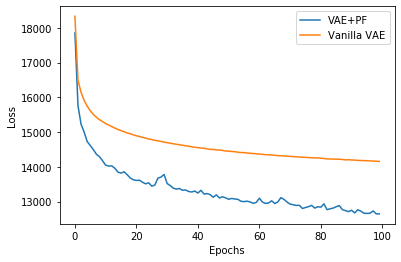

In [8]:
fig = plt.figure()
plt.plot(losses_pf)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(["VAE+PF", "Vanilla VAE"])
plt.show()

# Testing

In [25]:
# Set VAE to evaluation mode
vae.eval()
vae_pf.eval()

# As we did in training mode, simply store the loss and number of batches
# Now we only need one number because we don't have epochs
test_loss_vanilla, test_loss_pf, number_of_batches = 0.0, 0.0, 0

t = 0

for test_images, _ in testloader:
    beta = 1.0 #min(1, 0.01 + t / 700)

    # Do not track gradients
    with torch.no_grad():

        # Send images to the GPU/CPU
        test_images = test_images.to(device)

        # Forward computation for VAE and VAE+PF
        recon, mu, logvar = vae(test_images)
        recon_pf, log_q0, ladj_sum, log_pK = vae_pf(test_images)

        # Loss Vanilla
        BCE = F.binary_cross_entropy(recon.view(-1, 784), test_images.view(-1, 784), reduction='sum')
        KL  = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = BCE + KL
        
        # Loss Planar Flow
        BCE_pf = F.binary_cross_entropy(recon_pf.view(-1, 784), test_images.view(-1, 784), reduction='sum')
        KL_pf  = (log_q0 + ladj_sum - beta*log_pK).sum()
        loss_pf = beta*BCE_pf + KL_pf
        
        # Cumulative loss & Number of batches
        test_loss_vanilla += loss.item()
        test_loss_pf += loss_pf.item()
        number_of_batches += 1

# Now divide by number of batches to get average loss per batch
test_loss_vanilla /= number_of_batches
test_loss_pf /= number_of_batches
print('Vanilla average loss: %f' % (test_loss_vanilla))
print('PF average loss:      %f' % (test_loss_pf))

Vanilla average loss: 14801.106973
PF average loss:      12640.336670


# Comparing Reconstructions

In [26]:
def prepare_images(imgs, n=50, nrow=5, ncol=10):
    """Prepares n images by clipping the values to (0, 1) arranging them in a grid (nrow, ncol)
    and transposing them so that we can actually see the digits."""
    imgs = imgs.cpu().clamp(0, 1)[:n]
    imgs = make_grid(imgs, ncol, nrow).numpy()
    imgs = np.transpose(imgs, (1, 2, 0))
    return imgs

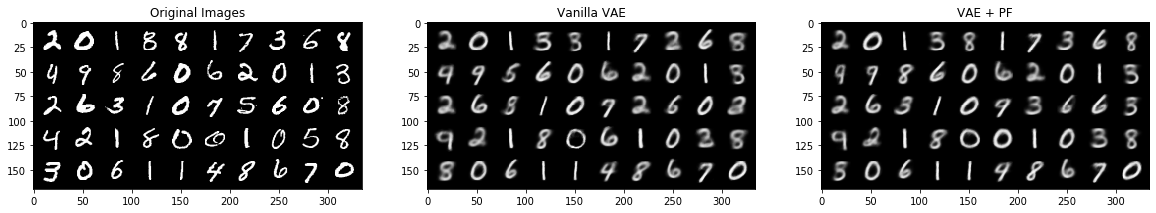

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 40))
with torch.no_grad():
    
    # ORIGINAL IMAGES
    axes[0].imshow(prepare_images(test_images))
    axes[0].set_title("Original Images")
    
    # VANILLA VAE
    axes[1].imshow(prepare_images(recon.view(batch_size, 1, 28, 28)))
    axes[1].set_title("Vanilla VAE")
    
    # VAE with Planar Flows
    axes[2].imshow(prepare_images(recon_pf.view(batch_size, 1, 28, 28)))
    axes[2].set_title("VAE + PF")
    

# Data Generation

* Don't just use batch size in flow etc, compute it from the data
* Modify decode to sample w, u, b
* set K and other parameters outside

In [41]:
def flow(z0, w, u, b):

    z_k = z0                                # (batch_size, 2, 1)               
    ladj_sum = torch.zeros((z.size(0), 1))  # (batch_size, 1)

    for k in range(vae_pf.K):
        # Grab parameters for this flow
        w_k = w[:, k, :, :]   # (batch_size, 1, 2)
        u_k = u[:, k, :, :]   # (batch_size, 2, 1)
        b_k = b[:, k, :, :]   # (batch_size, 1, 1)

        # Compute uhat to make f() invertible
        uw = torch.bmm(w_k, u_k)   # (batch_size, 1, 1)
        m_uw = -1 + F.softplus(uw) # size (batch_size, 1, 1)
        uhat_k = u_k + ((m_uw - uw)* w_k.transpose(2, 1) / (torch.norm(w_k, dim=2, keepdim=True)**2))

        # Compute z_{k+1} = f(z_k)
        wz_plus_b = torch.bmm(w_k, z_k) + b_k
        z_k_plus_1 = (z_k + uhat_k * torch.tanh(wz_plus_b)).squeeze(2) # (batch_size, 2, 1) --> (batch_size, 2)
        #print("z_{k+1}: ", z_k_plus_1.size())
        # Compute Log-Absolute-Determinant-Jacobian & add it to running sum
        h_prime = (1 - torch.tanh(wz_plus_b)**2)
        ladj = -(1 + torch.bmm(h_prime*w_k, uhat_k)).abs().add(1e-8).log().squeeze(2)
        ladj_sum += ladj

        # Set z_k <- z_{k+1}
        zk = z_k_plus_1

    z0, z_k = z0.squeeze(2), z_k.squeeze(2)
    return z0, zk, ladj_sum

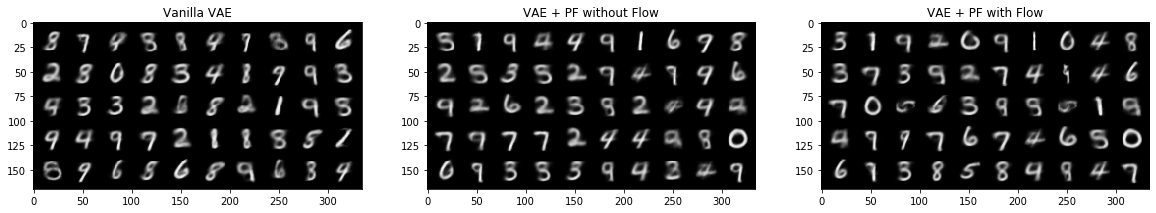

In [43]:
vae.eval()
vae_pf.eval()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

with torch.no_grad():
    # Sample from standard normal distribution
    z = torch.randn(50, latent_dim, device=device)

    # Vanilla VAE Reconstructions
    gen_images = vae.decode(z)
    
    # VAE + PF reconstructions without flow
    gen_images_pf = torch.sigmoid(vae_pf.d_hidden2image(torch.relu(vae_pf.d_latent2hidden(z))))
    
    # VAE + PF with flow
    u = torch.randn((50, 3, latent_dim, 1))
    w = torch.randn((50, 3, 1, latent_dim))
    b = torch.randn((50, 3, 1, 1))
    _, z_K, _ = flow(z.unsqueeze(2), w, u, b)
    gen_images_pf_flow = torch.sigmoid(vae_pf.d_hidden2image(torch.relu(vae_pf.d_latent2hidden(z_K))))

    # Vanilla VAE
    axes[0].imshow(prepare_images(gen_images.view(50, 1, 28, 28)))
    axes[0].set_title("Vanilla VAE")
    
    # VAE+PF without FLow
    axes[1].imshow(prepare_images(gen_images_pf.view(50, 1, 28, 28)))
    axes[1].set_title("VAE + PF without Flow")
    
    # VAE + PF with Flow
    axes[2].imshow(prepare_images(gen_images_pf_flow.view(50, 1, 28, 28)))
    axes[2].set_title("VAE + PF with Flow")